In [1]:
import arviz as az
import matplotlib as mpl
import matplotlib.pyplot as plt
import missingno as mno
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns
from IPython.display import display
from patsy import dmatrix

In [2]:
# az.style.use("arviz-darkgrid")
sns.set_theme()
# plt.rcParams["axes.grid"] = True
az.rcParams["stats.hdi_prob"] = 0.89

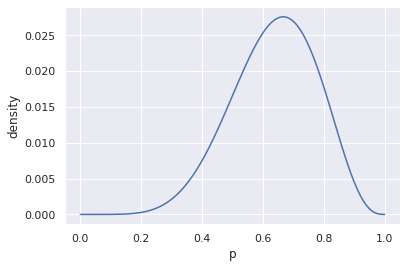

In [3]:
p_grid = np.linspace(0, 1, num=100)
prior = stats.uniform.pdf(p_grid, 0, 1)
likelihood = stats.binom.pmf(k=6, n=9, p=p_grid)
posterior = prior * likelihood
posterior /= posterior.sum()
fig, ax = plt.subplots()
ax.plot(p_grid, posterior)
ax.set(xlabel="p", ylabel="density");

# Chapter 4.3

In [4]:
df = pd.read_csv("data/Howell1.csv", sep=";")
df.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


In [5]:
df.describe()

,height,weight,age,male
count,544.000000,544.000000,544.000000,544.000000
mean,138.263596,35.610618,29.344393,0.472426
std,27.602448,14.719178,20.746888,0.499699
min,53.975000,4.252425,0.000000,0.000000
25%,125.095000,22.007717,12.000000,0.000000
50%,148.590000,40.057844,27.000000,0.000000
75%,157.480000,47.209005,43.000000,1.000000
max,179.070000,62.992589,88.000000,1.000000


In [6]:
az.summary(df.to_dict(orient="list"), kind="stats")

,mean,sd,hdi_5.5%,hdi_94.5%
height,138.264,27.602,90.805,170.180
weight,35.611,14.719,11.368,55.707
age,29.344,20.747,0.000,57.000
male,0.472,0.500,0.000,1.000


In [7]:
df.height

0      151.765
1      139.700
2      136.525
3      156.845
4      145.415
        ...   
539    145.415
540    162.560
541    156.210
542     71.120
543    158.750
Name: height, Length: 544, dtype: float64

In [8]:
adults = df[df.age >= 18]
adults.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


In [9]:
adults.describe()

,height,weight,age,male
count,352.000000,352.000000,352.000000,352.000000
mean,154.597093,44.990486,41.138494,0.468750
std,7.742332,6.456708,15.967855,0.499733
min,136.525000,31.071052,18.000000,0.000000
25%,148.590000,40.256290,28.000000,0.000000
50%,154.305000,44.792210,39.000000,0.000000
75%,160.655000,49.292693,51.000000,1.000000
max,179.070000,62.992589,88.000000,1.000000


In [10]:
with pm.Model() as heights_model:
    μ = pm.Normal("$μ$", 178, 20)
    σ = pm.Uniform("$σ$", 0, 50)
    height = pm.Normal("height", μ, σ, observed=adults.height)

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '1815408' (I am process '1815858')


In [11]:
with heights_model:
    trace_4_1 = pm.sample()

/home/jnassar/.local/lib/pyenv/versions/bayes/lib/python3.9/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [$σ$, $μ$]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


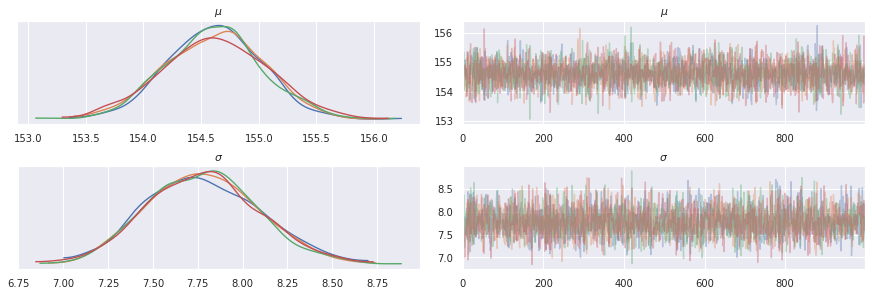

In [12]:
with heights_model:
    az.plot_trace(trace_4_1);

In [13]:
with heights_model:
    display(az.summary(trace_4_1, round_to=2, kind="stats"))

,mean,sd,hdi_5.5%,hdi_94.5%
$μ$,154.61,0.43,153.92,155.26
$σ$,7.78,0.31,7.27,8.25


/home/jnassar/.local/lib/pyenv/versions/bayes/lib/python3.9/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [$σ$, $μ$]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


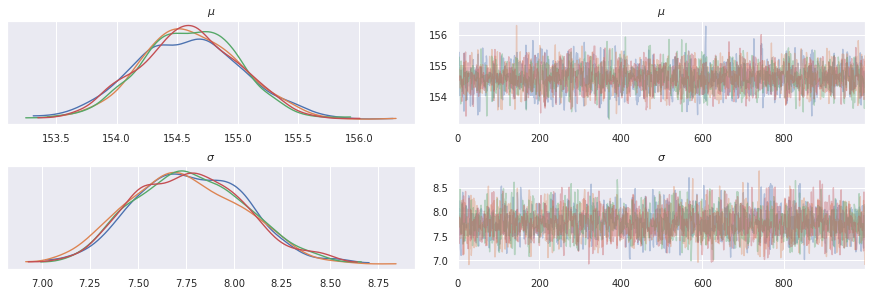

In [14]:
with pm.Model() as tested_model:
    μ = pm.Normal("$μ$", 178, 20, testval=adults.height.mean())
    σ = pm.Uniform("$σ$", 0, 50, testval=adults.height.std())
    height = pm.Normal("height", μ, σ, observed=adults.height)
    trace = pm.sample()
    az.plot_trace(trace)

/home/jnassar/.local/lib/pyenv/versions/bayes/lib/python3.9/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [$σ$, $μ$]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


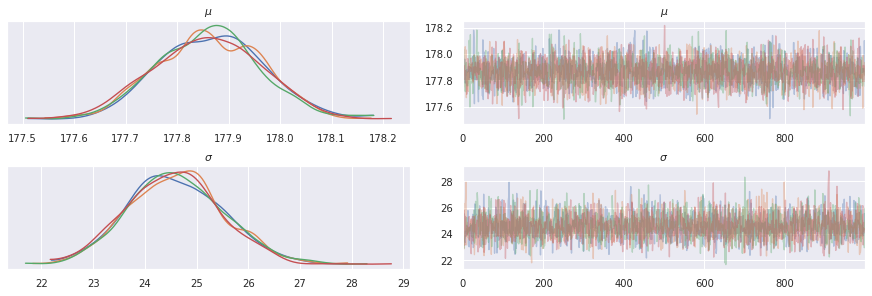

In [15]:
with pm.Model() as narrow_model:
    μ = pm.Normal("$μ$", 178, 0.1)
    σ = pm.Uniform("$σ$", 0, 50)
    height = pm.Normal("height", μ, σ, observed=adults.height)
    trace = pm.sample()
    az.plot_trace(trace)

In [16]:
with heights_model:
    trace_df = pm.trace_to_dataframe(trace_4_1)
trace_df.cov()

,$μ$,$σ$
$μ$,0.180844,-0.001710
$σ$,-0.001710,0.095954


In [17]:
trace_df.head()

,$μ$,$σ$
0,154.442481,7.770308
1,154.524241,7.541767
2,154.727903,7.815790
3,154.568985,7.736494
4,155.055195,7.879924


In [18]:
trace_df.columns

Index(['$μ$', '$σ$'], dtype='object')

In [19]:
with heights_model:
    display(az.summary(trace_4_1, kind="stats"))

,mean,sd,hdi_5.5%,hdi_94.5%
$μ$,154.614,0.425,153.919,155.265
$σ$,7.780,0.310,7.268,8.253


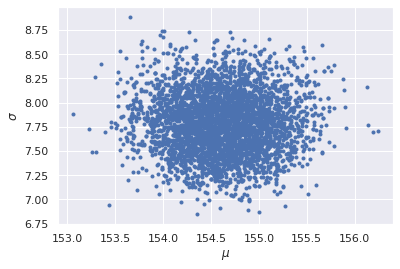

In [20]:
with heights_model:
    az.plot_pair(trace_4_1)

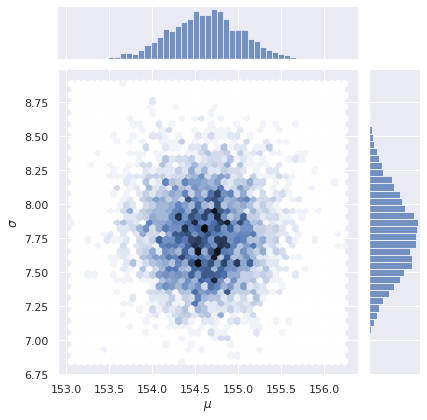

In [21]:
sns.jointplot(data=trace_df, x="$μ$", y="$σ$", kind="hex")

# Chapter 4.4

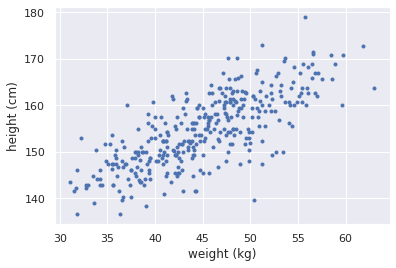

In [22]:
fig, ax = plt.subplots()
ax.plot(adults.weight, adults.height, linestyle="", marker=".")
ax.set(
    ylabel="height (cm)",
    xlabel="weight (kg)",
);

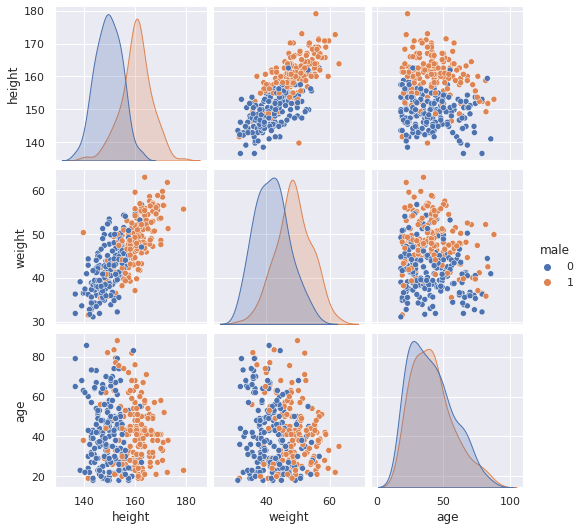

In [23]:
sns.pairplot(adults, hue="male")

In [24]:
N = 100
α = stats.norm.rvs(178, 20, N)
β = stats.lognorm.rvs(1, 1, size=N)

weights = np.linspace(30, 80, 100)
weights_mean = adults.weight.mean()

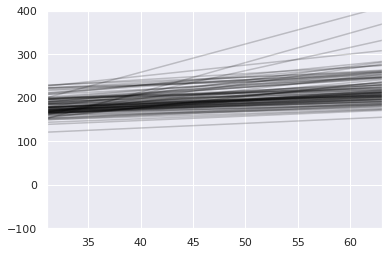

In [25]:
fig, ax = plt.subplots()
for i in range(N):
    ax.plot(α[i] + β[i] * (weights - weights_mean), color="black", alpha=0.2)
    ax.set(
        xlim=[adults.weight.min(), adults.weight.max()],
        ylim=[-100, 400],
    );

In [26]:
with pm.Model() as model_4_3:
    a = pm.Normal("α", mu=178, sd=20)
    b = pm.Lognormal("β", mu=0, sd=1)
    mu = a + b * (adults.weight - weights_mean)
    sigma = pm.Uniform("σ", 0, 50)
    height = pm.Normal("height", mu=mu, sd=sigma, observed=adults.height)
    trace_4_3 = pm.sample()

/home/jnassar/.local/lib/pyenv/versions/bayes/lib/python3.9/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%
α,154.606,0.281,154.152,155.038
β,0.903,0.043,0.841,0.977
σ,5.109,0.199,4.797,5.423


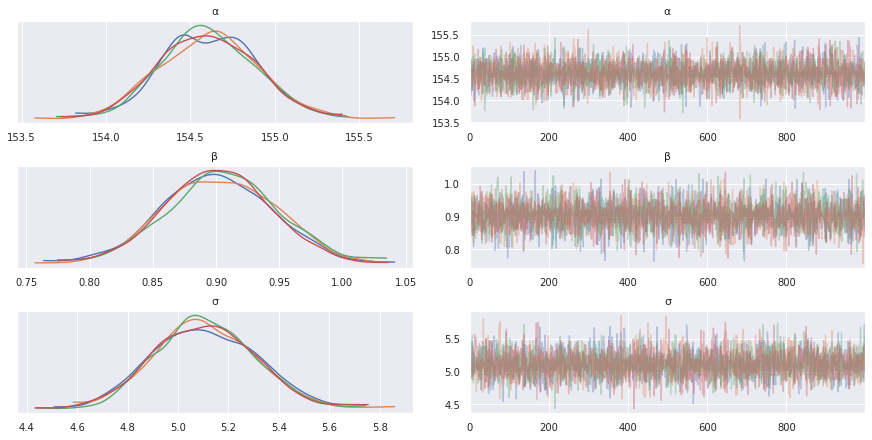

In [27]:
with model_4_3:
    display(az.summary(trace_4_3, kind="stats"))
    az.plot_trace(trace_4_3)

In [28]:
trace_4_3_df = pm.trace_to_dataframe(trace_4_3)
trace_4_3_df.cov().round(3)

,α,β,σ
α,0.079,0.000,-0.002
β,0.000,0.002,-0.000
σ,-0.002,-0.000,0.040


[Text(0.5, 0, 'weight'), Text(0, 0.5, 'height')]

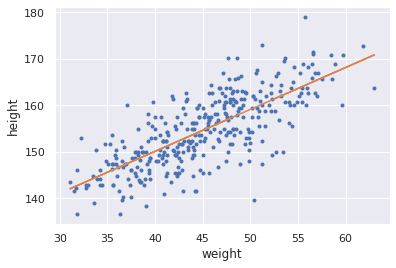

In [29]:
fig, ax = plt.subplots()
ax.plot(adults.weight, adults.height, ".")
ax.plot(
    adults.weight,
    trace_4_3["α"].mean() + trace_4_3["β"].mean() * (adults.weight - weights_mean),
)
ax.set(
    xlabel=adults.columns[1],
    ylabel=adults.columns[0],
)

In [30]:
trace_4_3_df.head()

,α,β,σ
0,155.108526,0.855223,5.228943
1,154.581831,0.880245,4.934661
2,154.898872,0.955186,5.351753
3,154.116492,0.880470,5.140432
4,154.750804,0.891816,5.320759


In [31]:
N = [10, 50, 150, 352][0]
adultsN = adults[:N]
with pm.Model() as model_4_4:
    a = pm.Normal("α", mu=178, sd=20)
    b = pm.Lognormal("β", mu=0, sd=1)
    mu = pm.Deterministic("μ", a + b * (adultsN.weight - adultsN.weight.mean()))
    sigma = pm.Uniform("σ", 0, 50)
    height = pm.Normal("height", mu=mu, sd=sigma, observed=adultsN.height)
    trace_4_4 = pm.sample()

/home/jnassar/.local/lib/pyenv/versions/bayes/lib/python3.9/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
The acceptance probability does not match the target. It is 0.8801908154974383, but should be close to 0.8. Try to increase the number of tuning steps.


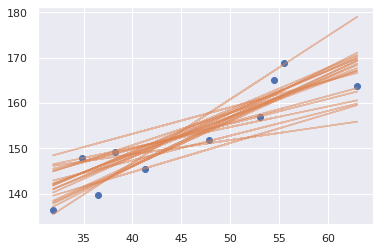

In [32]:
fig, ax = plt.subplots()
ax.plot(adultsN.weight, adultsN.height, linestyle="", marker="o")
rows = np.random.choice(trace_4_4, size=20)
for row in rows:
    ax.plot(
        adultsN.weight,
        row["α"] + row["β"] * (adultsN.weight - adultsN.weight.mean()),
        color="C1",
        alpha=0.5,
    )

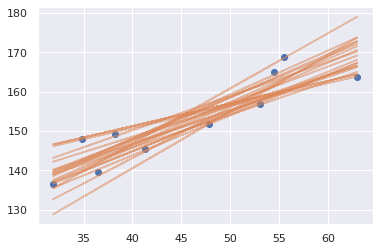

In [33]:
fig, ax = plt.subplots()
ax.plot(adultsN.weight, adultsN.height, linestyle="", marker="o")
rows = np.random.choice(trace_4_4, size=20)
for row in rows:
    ax.plot(adultsN.weight, row["μ"], color="C1", alpha=0.5)

/home/jnassar/.local/lib/pyenv/versions/bayes/lib/python3.9/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5469737225276831, but should be close to 0.8. Try to increase the number of tuning steps.
/home/jnassar/.local/lib/pyenv/versions/bayes/lib/python3.9/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
/home/jnassar/.local/lib/pyenv/versions/bayes/lib/python3.9/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
/home/jnassar/.local/lib/pyenv/versions/bayes/lib/python3.9/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


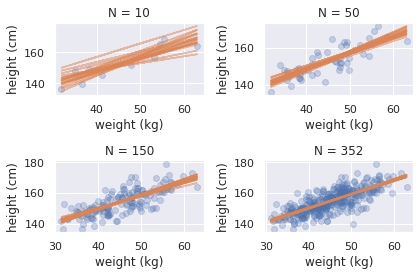

In [34]:
N = [10, 50, 150, 352]
fig, axes = plt.subplots(nrows=2, ncols=2)

for ax, n in zip(axes.ravel(), N):
    adultsN = adults[:n]
    with pm.Model() as model_4_4:
        a = pm.Normal("α", mu=178, sd=20)
        b = pm.Lognormal("β", mu=0, sd=1)
        mu = pm.Deterministic("μ", a + b * (adultsN.weight - adultsN.weight.mean()))
        sigma = pm.Uniform("σ", 0, 50)
        height = pm.Normal("height", mu=mu, sd=sigma, observed=adultsN.height)
        trace_4_4 = pm.sample()
    rows = np.random.choice(trace_4_4, size=20)
    ax.scatter(adultsN.weight, adultsN.height, alpha=0.25, color="C0")
    for row in rows:
        ax.plot(adultsN.weight, row["μ"], color="C1", alpha=0.5)
    ax.set(title=f"N = {n}", xlabel="weight (kg)", ylabel="height (cm)")

fig.tight_layout()

In [35]:
mu_at_50 = trace_4_3["α"] + trace_4_3["β"] * (50 - adults.weight.mean())
mu_at_50

array([159.39277976, 158.9914293 , 159.68389092, ..., 158.54415022,
       159.68273473, 159.072123  ])

[Text(0.5, 0, 'heights')]

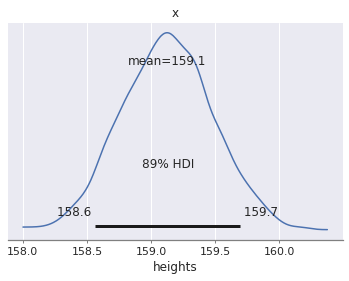

In [36]:
fig, ax = plt.subplots()
az.plot_posterior(mu_at_50, ax=ax, round_to=4)
ax.set(xlabel="heights")

In [37]:
az.hdi(mu_at_50)

array([158.56301553, 159.69746654])

In [38]:
weight_seq = np.arange(25, 71)
mu_pred = np.zeros((len(weight_seq), len(trace_4_3) * trace_4_3.nchains))
for i, w in enumerate(weight_seq):
    mu_pred[i] = trace_4_3["α"] + trace_4_3["β"] * (w - adults.weight.mean())

[Text(0.5, 0, 'weight'), Text(0, 0.5, 'height')]

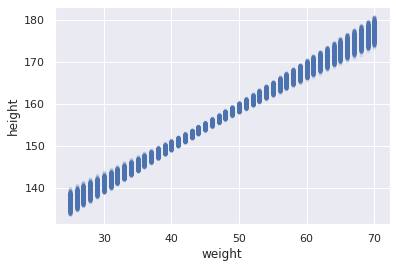

In [39]:
fig, ax = plt.subplots()
ax.plot(weight_seq, mu_pred, "C0.", alpha=0.1)
ax.set(xlabel="weight", ylabel="height")

In [40]:
mu_mean = mu_pred.mean(axis=1)
mu_hdi = az.hdi(mu_pred.T)

/home/jnassar/.local/lib/pyenv/versions/bayes/lib/python3.9/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


/home/jnassar/.local/lib/pyenv/versions/bayes/lib/python3.9/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


[Text(0.5, 1.0, 'average height spread'),
 Text(0.5, 0, 'weight'),
 Text(0, 0.5, 'height'),
 (30.071052, 63.992589)]

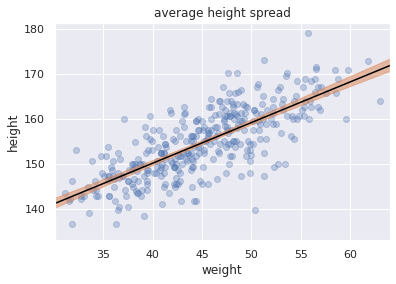

In [41]:
fig, ax = plt.subplots()
ax.scatter(adults.weight, adults.height, alpha=0.3)
ax.plot(weight_seq, mu_mean, color="black")
az.plot_hdi(weight_seq, mu_pred.T, ax=ax)
ax.set(
    title="average height spread",
    xlabel="weight",
    ylabel="height",
    xlim=[adults.weight.min() - 1, adults.weight.max() + 1],
)

In [42]:
with model_4_3:
    height_pred = pm.sample_posterior_predictive(trace_4_3, 200)

/home/jnassar/.local/lib/pyenv/versions/bayes/lib/python3.9/site-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [43]:
height_pred_hdi = az.hdi(height_pred["height"])

/home/jnassar/.local/lib/pyenv/versions/bayes/lib/python3.9/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


/home/jnassar/.local/lib/pyenv/versions/bayes/lib/python3.9/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/jnassar/.local/lib/pyenv/versions/bayes/lib/python3.9/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


[Text(0.5, 0, 'weight'), Text(0, 0.5, 'height'), (31.071052, 62.992589)]

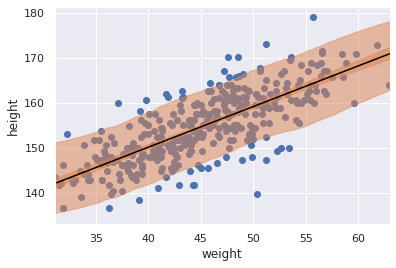

In [44]:
fig, ax = plt.subplots()
ax.scatter(adults.weight, adults.height)
ax.plot(weight_seq, mu_mean, color="black")
az.plot_hdi(weight_seq, mu_pred.T, ax=ax)
az.plot_hdi(adults.weight, height_pred["height"], hdi_prob=0.89, ax=ax)
ax.set(
    xlabel="weight", ylabel="height", xlim=[adults.weight.min(), adults.weight.max()]
)

In [45]:
weight_seg = np.arange(25, 1)
post_samples = []
for row in np.random.choice(trace_4_3, 1000):
    mu_pr = row["α"] + row["β"] * (weight_seq - adults.weight.mean())
    sigma_pred = row["σ"]
    post_samples.append(np.random.normal(mu_pr, sigma_pred))

/home/jnassar/.local/lib/pyenv/versions/bayes/lib/python3.9/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/jnassar/.local/lib/pyenv/versions/bayes/lib/python3.9/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


[Text(0.5, 0, 'weight'), Text(0, 0.5, 'height'), (31.071052, 62.992589)]

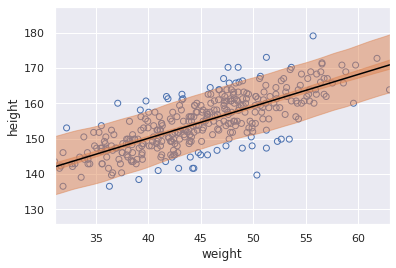

In [46]:
fig, ax = plt.subplots()
ax.scatter(adults.weight, adults.height, marker="o", edgecolor="C0", facecolor="none")
ax.plot(weight_seq, mu_mean, color="black")
az.plot_hdi(weight_seq, mu_pred.T, ax=ax)
az.plot_hdi(weight_seq, post_samples, ax=ax)
ax.set(
    xlabel="weight", ylabel="height", xlim=[adults.weight.min(), adults.weight.max()]
)

# Chapter 4.5

In [47]:
df.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


[Text(0.5, 0, 'weight'), Text(0, 0.5, 'height')]

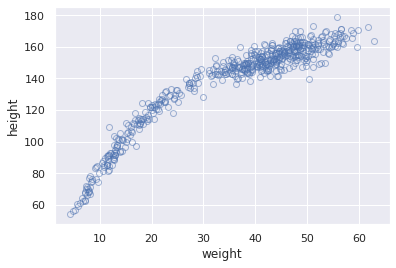

In [48]:
fig, ax = plt.subplots()
ax.plot(df.weight, df.height, marker="o", linestyle="", mfc="none", alpha=0.5)
ax.set(xlabel="weight", ylabel="height")

In [49]:
df["weight_standardized"] = (df.weight - df.weight.mean()) / df.weight.std()
df["weight_standardized2"] = df.weight_standardized ** 2
df["weight_standardized3"] = df.weight_standardized ** 3
df.head()

,height,weight,age,male,weight_standardized,weight_standardized2,weight_standardized3
0,151.765,47.825606,63.0,1,0.829869,0.688682,0.571516
1,139.700,36.485807,63.0,0,0.059459,0.003535,0.000210
2,136.525,31.864838,65.0,0,-0.254483,0.064762,-0.016481
3,156.845,53.041915,41.0,1,1.184257,1.402466,1.660881
4,145.415,41.276872,51.0,0,0.384957,0.148192,0.057048


In [50]:
with pm.Model() as m_4_5:
    a = pm.Normal("$α$", mu=178, sd=20)
    b1 = pm.Lognormal("$β_1$", mu=0, sd=1)
    b2 = pm.Normal("$β_2$", mu=0, sd=1)
    sigma = pm.Uniform("$σ$", lower=0, upper=50)
    mu = pm.Deterministic(
        "mu", a + b1 * df.weight_standardized + b2 * df.weight_standardized2
    )
    height = pm.Normal("height", mu=mu, sd=sigma, observed=df.height)
    trace_4_5 = pm.sample()

/home/jnassar/.local/lib/pyenv/versions/bayes/lib/python3.9/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [$σ$, $β_2$, $β_1$, $α$]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


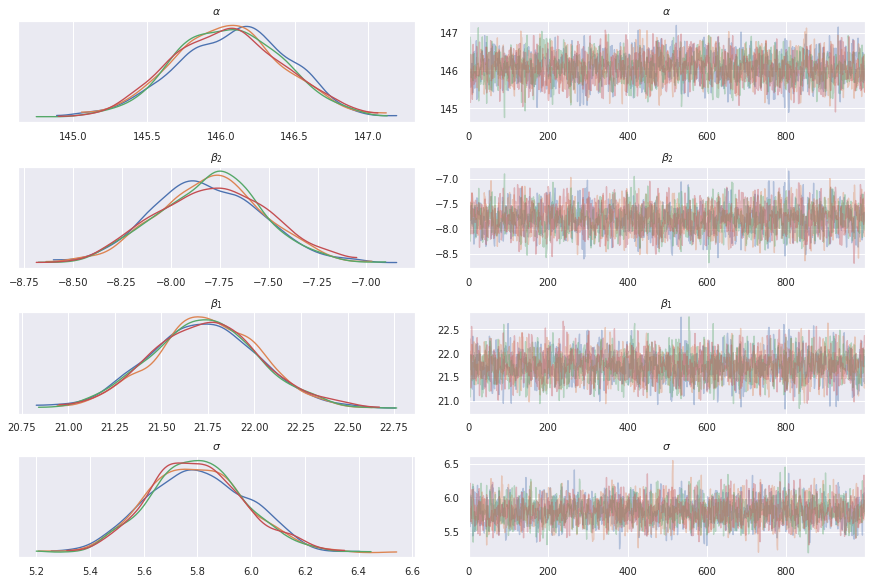

In [51]:
var_names = ["~mu"]
with m_4_5:
    az.plot_trace(trace_4_5, var_names)

In [52]:
with m_4_5:
    display(az.summary(trace_4_5, var_names, kind="stats", round_to=2))

,mean,sd,hdi_5.5%,hdi_94.5%
$α$,146.06,0.37,145.46,146.65
$β_2$,-7.80,0.28,-8.24,-7.36
$β_1$,21.74,0.29,21.24,22.18
$σ$,5.80,0.18,5.52,6.10


In [53]:
mu_pred = trace_4_5["mu"]
height_pred = pm.sample_posterior_predictive(trace_4_5, 200, model=m_4_5)

/home/jnassar/.local/lib/pyenv/versions/bayes/lib/python3.9/site-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


/home/jnassar/.local/lib/pyenv/versions/bayes/lib/python3.9/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/jnassar/.local/lib/pyenv/versions/bayes/lib/python3.9/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


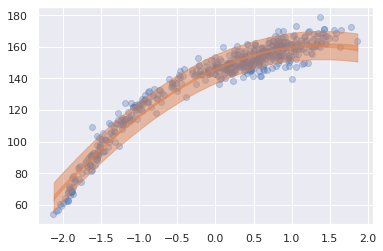

In [54]:
fig, ax = plt.subplots()
ax.scatter(df.weight_standardized, df.height, color="C0", alpha=0.3)
az.plot_hdi(df.weight_standardized, mu_pred, ax=ax)
az.plot_hdi(df.weight_standardized, height_pred["height"], ax=ax);

In [55]:
with pm.Model() as m_4_6:
    a = pm.Normal("α", mu=178, sd=20)
    b1 = pm.Lognormal("β_1", mu=0, sd=1)
    b2 = pm.Normal("β_2", mu=0, sd=1)
    b3 = pm.Normal("β_3", mu=0, sd=1)
    sigma = pm.Uniform("σ", lower=0, upper=50)
    mu = pm.Deterministic(
        "mu",
        a
        + b1 * df.weight_standardized
        + b2 * df.weight_standardized2
        + b3 * df.weight_standardized3,
    )
    height = pm.Normal("height", mu=mu, sd=sigma, observed=df.height)
    trace_4_6 = pm.sample()

/home/jnassar/.local/lib/pyenv/versions/bayes/lib/python3.9/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β_3, β_2, β_1, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


In [56]:
mu_pred = trace_4_6["mu"]
height_pred = pm.sample_posterior_predictive(trace_4_6, 200, model=m_4_6)

/home/jnassar/.local/lib/pyenv/versions/bayes/lib/python3.9/site-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


/home/jnassar/.local/lib/pyenv/versions/bayes/lib/python3.9/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/jnassar/.local/lib/pyenv/versions/bayes/lib/python3.9/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


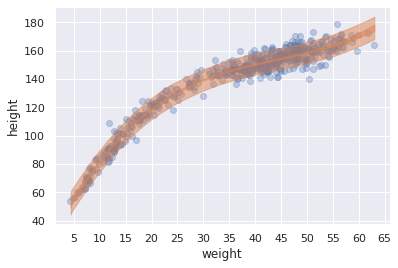

In [57]:
fig, ax = plt.subplots()
ax.scatter(df.weight_standardized, df.height, color="C0", alpha=0.3)
az.plot_hdi(df.weight_standardized, mu_pred, ax=ax)
az.plot_hdi(df.weight_standardized, height_pred["height"], ax=ax)

new_xtick_labels = np.arange(5, 66, 5)
new_xticks = (new_xtick_labels - df.weight.mean()) / df.weight.std()
ax.set(
    xticks=new_xticks,
    xticklabels=new_xtick_labels,
    xlabel="weight",
    ylabel="height",
);

In [58]:
weight_m = np.vstack(
    (df.weight_standardized, df.weight_standardized ** 2, df.weight_standardized ** 3)
)
with pm.Model() as m_4_6_2:
    a = pm.Normal("a", mu=178, sd=100)
    b = pm.Normal("b", mu=0, sd=10, shape=3)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    mu = pm.Deterministic("mu", a + b @ weight_m)
    height = pm.Normal("height", mu=mu, sd=sigma, observed=df.height)
    trace_4_6_2 = pm.sample()

/home/jnassar/.local/lib/pyenv/versions/bayes/lib/python3.9/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


/home/jnassar/.local/lib/pyenv/versions/bayes/lib/python3.9/site-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


/home/jnassar/.local/lib/pyenv/versions/bayes/lib/python3.9/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/jnassar/.local/lib/pyenv/versions/bayes/lib/python3.9/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


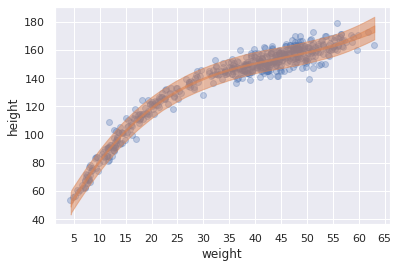

In [59]:
mu_pred = trace_4_6_2["mu"]
height_pred = pm.sample_posterior_predictive(trace_4_6_2, 200, m_4_6_2)

fig, ax = plt.subplots()
ax.scatter(df.weight_standardized, df.height, c="C0", alpha=0.3)
az.plot_hpd(df.weight_standardized, mu_pred, ax=ax)
az.plot_hpd(df.weight_standardized, height_pred["height"], ax=ax)

new_xtick_labels = np.arange(5, 66, 5)
new_xticks = (new_xtick_labels - df.weight.mean()) / df.weight.std()
ax.set(
    xticks=new_xticks,
    xticklabels=new_xtick_labels,
    xlabel="weight",
    ylabel="height",
);

In [62]:
new_xticks * df.weight.std() + df.weight.mean()

array([ 5., 10., 15., 20., 25., 30., 35., 40., 45., 50., 55., 60., 65.])

## Cherry blossoms

In [64]:
df = pd.read_csv("data/cherry_blossoms.csv")

In [65]:
df.describe()

,year,doy,temp,temp_upper,temp_lower
count,1215.000000,827.000000,1124.000000,1124.000000,1124.000000
mean,1408.000000,104.540508,6.141886,7.185151,5.098941
std,350.884596,6.407036,0.663648,0.992921,0.850350
min,801.000000,86.000000,4.670000,5.450000,0.750000
25%,1104.500000,100.000000,5.700000,6.480000,4.610000
50%,1408.000000,105.000000,6.100000,7.040000,5.145000
75%,1711.500000,109.000000,6.530000,7.720000,5.542500
max,2015.000000,124.000000,8.300000,12.100000,7.740000


In [66]:
df.dropna().describe()

,year,doy,temp,temp_upper,temp_lower
count,787.000000,787.00000,787.000000,787.000000,787.000000
mean,1533.395172,104.92122,6.100356,6.937560,5.263545
std,291.122597,6.25773,0.683410,0.811986,0.762194
min,851.000000,86.00000,4.690000,5.450000,2.610000
25%,1318.000000,101.00000,5.625000,6.380000,4.770000
50%,1563.000000,105.00000,6.060000,6.800000,5.250000
75%,1778.500000,109.00000,6.460000,7.375000,5.650000
max,1980.000000,124.00000,8.300000,12.100000,7.740000


In [67]:
az.summary(df.dropna().to_dict(orient="list"), kind="stats")

,mean,sd,hdi_5.5%,hdi_94.5%
year,1533.395,291.123,1123.00,1978.00
doy,104.921,6.258,95.00,114.00
temp,6.100,0.683,5.00,7.13
temp_upper,6.938,0.812,5.57,7.98
temp_lower,5.264,0.762,4.12,6.40


<AxesSubplot:>

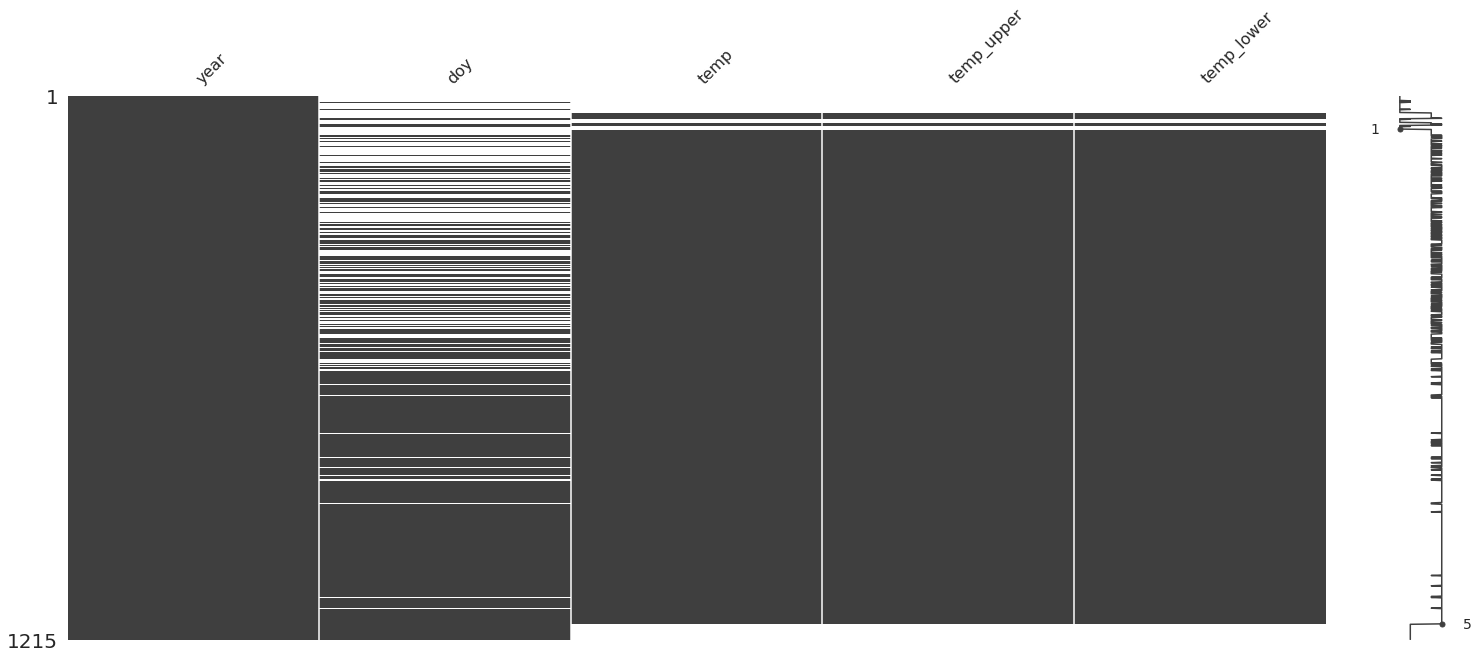

In [68]:
mno.matrix(df)

[Text(0.5, 0, 'year'), Text(0, 0.5, 'temp (°C)')]

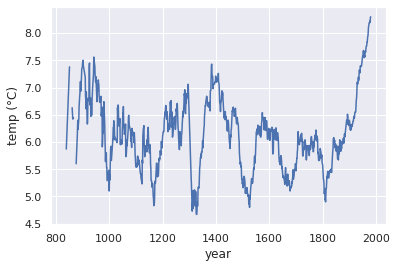

In [69]:
fig, ax = plt.subplots()
ax.plot(df.year, df.temp)
ax.set(xlabel="year", ylabel="temp (°C)")

In [70]:
d2 = df.dropna(subset=["temp"])
d2.describe()

,year,doy,temp,temp_upper,temp_lower
count,1124.000000,787.00000,1124.000000,1124.000000,1124.000000
mean,1418.243772,104.92122,6.141886,7.185151,5.098941
std,325.058651,6.25773,0.663648,0.992921,0.850350
min,839.000000,86.00000,4.670000,5.450000,0.750000
25%,1137.750000,101.00000,5.700000,6.480000,4.610000
50%,1418.500000,105.00000,6.100000,7.040000,5.145000
75%,1699.250000,109.00000,6.530000,7.720000,5.542500
max,1980.000000,124.00000,8.300000,12.100000,7.740000


In [71]:
n_knots = 15
knot_list = np.quantile(d2.year, np.linspace(0, 1, n_knots))
knot_list

array([ 839.        ,  937.21428571, 1017.42857143, 1097.64285714,
       1177.85714286, 1258.07142857, 1338.28571429, 1418.5       ,
       1498.71428571, 1578.92857143, 1659.14285714, 1739.35714286,
       1819.57142857, 1899.78571429, 1980.        ])

In [72]:
bases = dmatrix(
    "bs(year, knots=knots, degree=3, include_intercept=True) - 1",
    {"year": d2.year.values, "knots": knot_list[1:-1]},
)
bases

DesignMatrix with shape (1124, 17)
  Columns:
    ['bs(year, knots=knots, degree=3, include_intercept=True)[0]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[1]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[2]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[3]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[4]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[5]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[6]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[7]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[8]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[9]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[10]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[11]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[12]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[13]',
     'bs(yea

In [73]:
knot_list

array([ 839.        ,  937.21428571, 1017.42857143, 1097.64285714,
       1177.85714286, 1258.07142857, 1338.28571429, 1418.5       ,
       1498.71428571, 1578.92857143, 1659.14285714, 1739.35714286,
       1819.57142857, 1899.78571429, 1980.        ])

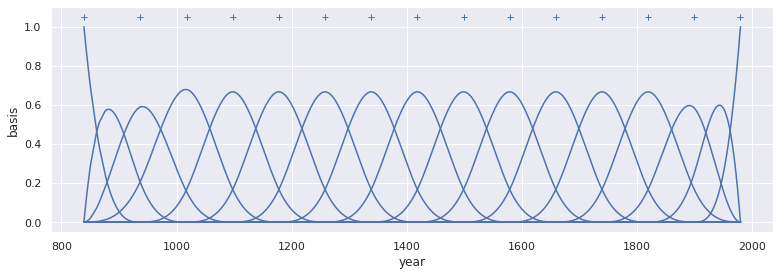

In [74]:
fig, ax = plt.subplots(figsize=(11, 4))
for basis in bases.T:
    ax.plot(d2.year, basis, color="C0")
ax.plot(knot_list, ax.get_ylim()[1] * np.ones_like(knot_list), "+")
ax.set(xlabel="year", ylabel="basis")
fig.tight_layout()

In [75]:
with pm.Model() as m_4_7:
    a = pm.Normal("a", 6, 10)
    w = pm.Normal("w", mu=0, sd=1, shape=bases.shape[1])
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + pm.math.dot(bases, w.T))
    temps = pm.Normal("T", mu=mu, sigma=sigma, observed=d2.temp)
    trace_4_7 = pm.sample()

/home/jnassar/.local/lib/pyenv/versions/bayes/lib/python3.9/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, w, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
There were 877 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.563398903116953, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


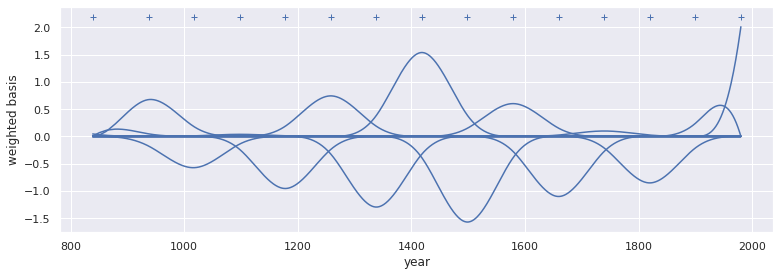

In [76]:
weights = trace_4_7[w].mean(axis=0)

fig, ax = plt.subplots(figsize=(11, 4))
for weight, basis in zip(weights, bases.T):
    ax.plot(d2.year, weight * basis, color="C0")
ax.plot(knot_list, ax.get_ylim()[1] * np.ones_like(knot_list), "+")
ax.set(xlabel="year", ylabel="weighted basis")
fig.tight_layout()

/home/jnassar/.local/lib/pyenv/versions/bayes/lib/python3.9/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


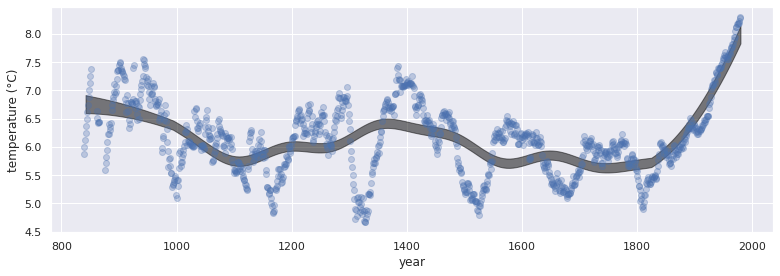

In [77]:
fig, ax = plt.subplots(figsize=(11, 4))
ax.plot(d2.year, d2.temp, "o", alpha=0.3)
az.plot_hdi(d2.year, trace_4_7["mu"], hdi_prob=0.97, color="black", ax=ax)
ax.set(xlabel="year", ylabel="temperature (°C)")
fig.tight_layout()